In [125]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges, negative_sampling
import networkx as nx
import numpy as np

from shapely.geometry import MultiLineString, Point
import geopandas as gp
from sklearn.model_selection import RandomizedSearchCV

In [4]:
df = gp.read_file('queensntest.geojson')

In [34]:
df.head()

,East Flushing,Woodhaven,Auburndale,Murray Hill,East Elmhurst,Cambria Heights,Elmhurst,Glen Oaks-Floral Park-New Hyde Park,Hammels-Arverne-Edgemere,Jackson Heights,...,Breezy Point-Belle Harbor-Rockaway Park-Broad Channel,Far Rockaway-Bayswater,Rosedale,Flushing,Queensboro Hill,Forest Hills,park-cemetery-etc-Queens,Springfield Gardens South-Brookville,Airport,geometry
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,"MULTILINESTRING ((-73.81733 40.66489, -73.8167..."
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,"MULTILINESTRING ((-73.81939 40.70765, -73.8188..."
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,"MULTILINESTRING ((-73.82472 40.75549, -73.8239..."
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,"MULTILINESTRING ((-73.77800 40.71405, -73.7773..."
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,"MULTILINESTRING ((-73.78302 40.68428, -73.7826..."


In [23]:
G = nx.Graph()
point_to_id = {}
current_id = 0

In [21]:
def add_multilinestring_to_graph(mls, properties, G, point_to_id, current_id):
    for linestring in list(mls.geoms):
        for i in range(len(linestring.coords) - 1):
            p1 = Point(linestring.coords[i])
            p2 = Point(linestring.coords[i + 1])
            if p1 not in point_to_id:
                point_to_id[p1] = current_id
                current_id += 1
            if p2 not in point_to_id:
                point_to_id[p2] = current_id
                current_id += 1
            G.add_node(point_to_id[p1], **properties)
            G.add_node(point_to_id[p2], **properties)
            G.add_edge(point_to_id[p1], point_to_id[p2])

In [24]:
for idx, row in df.iterrows():
    properties = row.drop('geometry').to_dict()
    add_multilinestring_to_graph(row['geometry'], properties, G, point_to_id, current_id)

In [27]:
# Extract edges and convert them to a list of tuples of node indices
edges = list(G.edges())
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Create a PyG Data object
data = Data(edge_index=edge_index, num_nodes=G.number_of_nodes())

# Generate random features for the nodes (replace with actual features if available)
x = torch.eye(G.number_of_nodes())

# Split edges into train, val, and test
transform = torch_geometric.transforms.RandomLinkSplit(is_undirected=False)
train_data, val_data, test_data = transform(data)

In [35]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Data

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Assume x and edge_index are already defined
x = torch.eye(G.number_of_nodes())  # Replace with actual features if available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=x.size(1), out_channels=1).to(device)

x, edge_index = x.to(device), train_data.edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index).squeeze()  # Output shape is [num_nodes]
    
    # Positive samples
    pos_out = out[train_data.edge_label_index[0]]
    pos_loss = F.binary_cross_entropy_with_logits(
        pos_out,
        torch.ones(pos_out.size(0), device=device)
    )
    
    # Negative samples
    neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=train_data.edge_label_index.size(1))
    neg_out = out[neg_edge_index[0]]
    neg_loss = F.binary_cross_entropy_with_logits(
        neg_out,
        torch.zeros(neg_out.size(0), device=device)
    )
    
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    z = model(x, edge_index)

# Link prediction and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Function to get edge features (embeddings of node pairs)
def get_edge_features(edge_list, z):
    return torch.cat([z[edge_list[0]], z[edge_list[1]]], dim=-1).cpu().numpy()

# Get train and test edge features
train_edge_index = train_data.edge_label_index
train_neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=train_edge_index.size(1))

train_edges = torch.cat([train_edge_index, train_neg_edge_index], dim=-1)
train_labels = torch.cat([torch.ones(train_edge_index.size(1)), torch.zeros(train_neg_edge_index.size(1))])

train_edge_features = get_edge_features(train_edges, z)

test_edge_index = test_data.edge_label_index
test_neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=test_edge_index.size(1))

test_edges = torch.cat([test_edge_index, test_neg_edge_index], dim=-1)
test_labels = torch.cat([torch.ones(test_edge_index.size(1)), torch.zeros(test_neg_edge_index.size(1))])

test_edge_features = get_edge_features(test_edges, z)

# Train a classifier
clf = LogisticRegression()
clf.fit(train_edge_features, train_labels)

# Predict and evaluate
test_preds = clf.predict_proba(test_edge_features)[:, 1]
auc = roc_auc_score(test_labels, test_preds)
print(f"AUC: {auc:.4f}")

Epoch 0, Loss: 1.3993
Epoch 10, Loss: 1.3532
Epoch 20, Loss: 1.3172
Epoch 30, Loss: 1.3179
Epoch 40, Loss: 1.3037
Epoch 50, Loss: 1.2955
Epoch 60, Loss: 1.2915
Epoch 70, Loss: 1.2565
Epoch 80, Loss: 1.2779
Epoch 90, Loss: 1.2601
Epoch 100, Loss: 1.2676
Epoch 110, Loss: 1.2717
Epoch 120, Loss: 1.2779
Epoch 130, Loss: 1.2348
Epoch 140, Loss: 1.2308
Epoch 150, Loss: 1.2300
Epoch 160, Loss: 1.2414
Epoch 170, Loss: 1.2260
Epoch 180, Loss: 1.2608
Epoch 190, Loss: 1.2587
AUC: 0.5647


In [36]:
between = np.load('between.npy',allow_pickle='TRUE').item()

In [103]:
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Load previously computed betweenness centrality
between = np.load('between.npy', allow_pickle=True).item()

# Step 2: Map Betweenness Centrality to Graph Nodes
# Create node_features array based on betweenness centrality
node_features = []
node_to_index = {}  # Map Point objects to unique integer indices
for idx, node in enumerate(G.nodes()):
    node_to_index[node] = idx
    point = node  # Assuming node is a Point object
    if point in between:
        node_features.append(between[point])
    else:
        node_features.append(0.0)  # Handle nodes without betweenness centrality

node_features = torch.tensor(node_features, dtype=torch.float32).unsqueeze(1)

# Step 3: Create Edge Index
edges = list(G.edges())
edge_index = torch.tensor([[node_to_index[edge[0]], node_to_index[edge[1]]] for edge in edges], dtype=torch.long).t().contiguous()

# Step 4: Create PyG Data object
data = Data(x=node_features, edge_index=edge_index, num_nodes=G.number_of_nodes())

# Step 5: Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Step 6: Split data into train and test sets for link prediction
transform = torch_geometric.transforms.RandomLinkSplit(is_undirected=False)
train_data, val_data, test_data = transform(data)

# Step 7: Initialize the GCN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=node_features.size(1), out_channels=1).to(device)

x, edge_index = node_features.to(device), train_data.edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Step 8: Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index).squeeze()  # Output shape is [num_nodes]
    
    # Positive samples
    pos_out = out[train_data.edge_label_index[0]]
    pos_loss = F.binary_cross_entropy_with_logits(
        pos_out,
        torch.ones(pos_out.size(0), device=device)
    )
    
    # Negative samples
    neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=train_data.edge_label_index.size(1))
    neg_out = out[neg_edge_index[0]]
    neg_loss = F.binary_cross_entropy_with_logits(
        neg_out,
        torch.zeros(neg_out.size(0), device=device)
    )
    
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Step 9: Train the model
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Step 10: Evaluate the model
model.eval()
with torch.no_grad():
    z = model(x, edge_index)

# Step 11: Get edge features for link prediction
def get_edge_features(edge_list, z):
    return torch.cat([z[edge_list[0]], z[edge_list[1]]], dim=-1).cpu().numpy()

train_edge_index = train_data.edge_label_index
train_neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=train_edge_index.size(1))

train_edges = torch.cat([train_edge_index, train_neg_edge_index], dim=-1)
train_labels = torch.cat([torch.ones(train_edge_index.size(1)), torch.zeros(train_neg_edge_index.size(1))])

train_edge_features = get_edge_features(train_edges, z)

test_edge_index = test_data.edge_label_index
test_neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=test_edge_index.size(1))

test_edges = torch.cat([test_edge_index, test_neg_edge_index], dim=-1)
test_labels = torch.cat([torch.ones(test_edge_index.size(1)), torch.zeros(test_neg_edge_index.size(1))])

test_edge_features = get_edge_features(test_edges, z)

# Step 12: Train a classifier
clf = LogisticRegression()
clf.fit(train_edge_features, train_labels)

# Step 13: Predict and evaluate
test_preds = clf.predict_proba(test_edge_features)[:, 1]
auc = roc_auc_score(test_labels, test_preds)
print(f"AUC: {auc:.4f}")

Epoch 0, Loss: 1.3863
Epoch 10, Loss: 1.3855
Epoch 20, Loss: 1.3847
Epoch 30, Loss: 1.3841
Epoch 40, Loss: 1.3834
Epoch 50, Loss: 1.3833
Epoch 60, Loss: 1.3826
Epoch 70, Loss: 1.3823
Epoch 80, Loss: 1.3819
Epoch 90, Loss: 1.3815
Epoch 100, Loss: 1.3821
Epoch 110, Loss: 1.3820
Epoch 120, Loss: 1.3815
Epoch 130, Loss: 1.3808
Epoch 140, Loss: 1.3817
Epoch 150, Loss: 1.3817
Epoch 160, Loss: 1.3815
Epoch 170, Loss: 1.3808
Epoch 180, Loss: 1.3810
Epoch 190, Loss: 1.3812
AUC: 0.4552


Using degrees

In [45]:
degrees = dict(nx.degree(G))
nodes = list(G.nodes())
node_features = np.array([degrees[node] for node in nodes])

In [52]:
degrees = dict(nx.degree(G))
nodes = list(G.nodes())
node_features = np.array([degrees[node] for node in nodes])

# Step 3: Create Edge Index
edges = list(G.edges())
edge_index = torch.tensor([[node_to_index[edge[0]], node_to_index[edge[1]]] for edge in edges], dtype=torch.long).t().contiguous()

# Step 4: Create PyG Data object
data = Data(x=node_features, edge_index=edge_index, num_nodes=G.number_of_nodes())

# Step 5: Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Step 6: Split data into train and test sets for link prediction
transform = torch_geometric.transforms.RandomLinkSplit(is_undirected=False)
train_data, val_data, test_data = transform(data)

# Step 7: Initialize the GCN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure node_features is converted to torch tensor
node_features_tensor = torch.tensor(node_features, dtype=torch.float32).to(device)

# Initialize the GCN model with correct in_channels and out_channels
if len(node_features_tensor.shape) == 1:
    node_features_tensor = node_features_tensor.unsqueeze(1)
in_channels = node_features_tensor.shape[1]  # Assuming node_features_tensor is 2D
model = GCN(in_channels=in_channels, out_channels=1).to(device)

# Assuming node_features_tensor is passed to the model, update your training loop accordingly
x, edge_index = node_features_tensor, train_data.edge_index.to(device)

# Assuming node_features_tensor is passed to the model, update your training loop accordingly
x, edge_index = node_features_tensor, train_data.edge_index.to(device)

# Step 8: Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index).squeeze()  # Output shape is [num_nodes]
    
    # Positive samples
    pos_out = out[train_data.edge_label_index[0]]
    pos_loss = F.binary_cross_entropy_with_logits(
        pos_out,
        torch.ones(pos_out.size(0), device=device)
    )
    
    # Negative samples
    neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=train_data.edge_label_index.size(1))
    neg_out = out[neg_edge_index[0]]
    neg_loss = F.binary_cross_entropy_with_logits(
        neg_out,
        torch.zeros(neg_out.size(0), device=device)
    )
    
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Step 9: Train the model
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Step 10: Evaluate the model
model.eval()
with torch.no_grad():
    z = model(x, edge_index)

# Step 11: Get edge features for link prediction
def get_edge_features(edge_list, z):
    return torch.cat([z[edge_list[0]], z[edge_list[1]]], dim=-1).cpu().numpy()

train_edge_index = train_data.edge_label_index
train_neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=train_edge_index.size(1))

train_edges = torch.cat([train_edge_index, train_neg_edge_index], dim=-1)
train_labels = torch.cat([torch.ones(train_edge_index.size(1)), torch.zeros(train_neg_edge_index.size(1))])

train_edge_features = get_edge_features(train_edges, z)

test_edge_index = test_data.edge_label_index
test_neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=test_edge_index.size(1))

test_edges = torch.cat([test_edge_index, test_neg_edge_index], dim=-1)
test_labels = torch.cat([torch.ones(test_edge_index.size(1)), torch.zeros(test_neg_edge_index.size(1))])

test_edge_features = get_edge_features(test_edges, z)

# Step 12: Train a classifier
clf = LogisticRegression()
clf.fit(train_edge_features, train_labels)

# Step 13: Predict and evaluate
test_preds = clf.predict_proba(test_edge_features)[:, 1]
auc = roc_auc_score(test_labels, test_preds)
print(f"AUC: {auc:.4f}")

Epoch 0, Loss: 1.5968
Epoch 10, Loss: 1.5971
Epoch 20, Loss: 1.5975
Epoch 30, Loss: 1.5973
Epoch 40, Loss: 1.5963
Epoch 50, Loss: 1.5971
Epoch 60, Loss: 1.5972
Epoch 70, Loss: 1.5973
Epoch 80, Loss: 1.5968
Epoch 90, Loss: 1.5969
Epoch 100, Loss: 1.5966
Epoch 110, Loss: 1.5967
Epoch 120, Loss: 1.5971
Epoch 130, Loss: 1.5968
Epoch 140, Loss: 1.5967
Epoch 150, Loss: 1.5965
Epoch 160, Loss: 1.5960
Epoch 170, Loss: 1.5964
Epoch 180, Loss: 1.5972
Epoch 190, Loss: 1.5964
AUC: 0.4578


In [54]:
import pickle
with open('node2vec_model.pkl', 'rb') as f:
    model = pickle.load(f)
node_embeddings = model.wv

In [55]:
node_to_embedding = {str(node): node_embeddings[str(node)] for node in G.nodes()}

In [90]:
# Get nodes and their corresponding embeddings
nodes = list(G.nodes())
node_features = np.array([node_to_embedding[str(node)] for node in nodes])

# Convert to PyTorch tensor
node_features_tensor = torch.tensor(node_features, dtype=torch.float)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Initialize GCN model with the number of features from node embeddings
model = GCN(in_channels=node_features_tensor.shape[1], out_channels=1)

In [91]:
x, edge_index = node_features_tensor, train_data.edge_index.to(device)

# Step 8: Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index).squeeze()  # Output shape is [num_nodes]
    
    # Positive samples
    pos_out = out[train_data.edge_label_index[0]]
    pos_loss = F.binary_cross_entropy_with_logits(
        pos_out,
        torch.ones(pos_out.size(0), device=device)
    )
    
    # Negative samples
    neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=train_data.edge_label_index.size(1))
    neg_out = out[neg_edge_index[0]]
    neg_loss = F.binary_cross_entropy_with_logits(
        neg_out,
        torch.zeros(neg_out.size(0), device=device)
    )
    
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Step 9: Train the model
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Step 10: Evaluate the model
model.eval()
with torch.no_grad():
    z = model(x, edge_index)

# Step 11: Get edge features for link prediction
def get_edge_features(edge_list, z):
    return torch.cat([z[edge_list[0]], z[edge_list[1]]], dim=-1).cpu().numpy()

train_edge_index = train_data.edge_label_index
train_neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=train_edge_index.size(1))

train_edges = torch.cat([train_edge_index, train_neg_edge_index], dim=-1)
train_labels = torch.cat([torch.ones(train_edge_index.size(1)), torch.zeros(train_neg_edge_index.size(1))])

train_edge_features = get_edge_features(train_edges, z)

test_edge_index = test_data.edge_label_index
test_neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=test_edge_index.size(1))

test_edges = torch.cat([test_edge_index, test_neg_edge_index], dim=-1)
test_labels = torch.cat([torch.ones(test_edge_index.size(1)), torch.zeros(test_neg_edge_index.size(1))])

test_edge_features = get_edge_features(test_edges, z)

# Step 12: Train a classifier
clf = LogisticRegression()
clf.fit(train_edge_features, train_labels)

# Step 13: Predict and evaluate
test_preds = clf.predict_proba(test_edge_features)[:, 1]
auc = roc_auc_score(test_labels, test_preds)
print(f"AUC: {auc:.4f}")

Epoch 0, Loss: 1.5285
Epoch 10, Loss: 1.5271
Epoch 20, Loss: 1.5281
Epoch 30, Loss: 1.5276
Epoch 40, Loss: 1.5335
Epoch 50, Loss: 1.5286
Epoch 60, Loss: 1.5242
Epoch 70, Loss: 1.5230
Epoch 80, Loss: 1.5269
Epoch 90, Loss: 1.5261
Epoch 100, Loss: 1.5263
Epoch 110, Loss: 1.5226
Epoch 120, Loss: 1.5262
Epoch 130, Loss: 1.5331
Epoch 140, Loss: 1.5292
Epoch 150, Loss: 1.5343
Epoch 160, Loss: 1.5217
Epoch 170, Loss: 1.5207
Epoch 180, Loss: 1.5305
Epoch 190, Loss: 1.5304
AUC: 0.4976


In [114]:
degree_features

array([2., 2., 2., ..., 2., 2., 2.], dtype=float32)

In [115]:
betweenness_features

array([[0.03128527],
       [0.03131986],
       [0.02260798],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

In [116]:
degree_features.shape

(16862,)

In [117]:
betweenness_features.shape

(16862, 1)

In [119]:
import torch_geometric.transforms as T

In [123]:
degree_features_expanded = np.expand_dims(degree_features, axis=1)
node2vec_features_expanded = np.expand_dims(node2vec_features, axis=1)

# Concatenate degree_features_expanded and betweenness_features along axis 1
combined_features = np.concatenate([degree_features_expanded, betweenness_features, node2vec_features_expanded], axis=1)

# Convert combined_features into a PyTorch tensor and unsqueeze if necessary
node_features = torch.tensor(combined_features, dtype=torch.float32)

# Step 3: Create Edge Index
edges = list(G.edges())
edge_index = torch.tensor([[node_to_index[edge[0]], node_to_index[edge[1]]] for edge in edges], dtype=torch.long).t().contiguous()

# Step 4: Create PyG Data object
data = Data(x=node_features, edge_index=edge_index, num_nodes=G.number_of_nodes())

# Step 5: Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Step 6: Split data into train and test sets for link prediction
transform = T.RandomLinkSplit(is_undirected=False)
train_data, val_data, test_data = transform(data)

# Step 7: Initialize the GCN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=node_features.size(1), out_channels=1).to(device)

x, edge_index = node_features.to(device), train_data.edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Step 8: Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index).squeeze()  # Output shape is [num_nodes]
    
    # Positive samples
    pos_out = out[train_data.edge_label_index[0]]
    pos_loss = F.binary_cross_entropy_with_logits(
        pos_out,
        torch.ones(pos_out.size(0), device=device)
    )
    
    # Negative samples
    neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=train_data.edge_label_index.size(1))
    neg_out = out[neg_edge_index[0]]
    neg_loss = F.binary_cross_entropy_with_logits(
        neg_out,
        torch.zeros(neg_out.size(0), device=device)
    )
    
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()
    return loss.item()

# Step 9: Train the model
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Step 10: Evaluate the model
model.eval()
with torch.no_grad():
    z = model(x, edge_index)

# Step 11: Get edge features for link prediction
def get_edge_features(edge_list, z):
    return torch.cat([z[edge_list[0]], z[edge_list[1]]], dim=-1).cpu().numpy()

train_edge_index = train_data.edge_label_index
train_neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=train_edge_index.size(1))

train_edges = torch.cat([train_edge_index, train_neg_edge_index], dim=-1)
train_labels = torch.cat([torch.ones(train_edge_index.size(1)), torch.zeros(train_neg_edge_index.size(1))])

train_edge_features = get_edge_features(train_edges, z)

test_edge_index = test_data.edge_label_index
test_neg_edge_index = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=test_edge_index.size(1))

test_edges = torch.cat([test_edge_index, test_neg_edge_index], dim=-1)
test_labels = torch.cat([torch.ones(test_edge_index.size(1)), torch.zeros(test_neg_edge_index.size(1))])

test_edge_features = get_edge_features(test_edges, z)

# Step 12: Train a classifier
clf = LogisticRegression()
clf.fit(train_edge_features, train_labels)

# Step 13: Predict and evaluate
test_preds = clf.predict_proba(test_edge_features)[:, 1]
auc = roc_auc_score(test_labels, test_preds)
print(f"AUC: {auc:.4f}")

Epoch 0, Loss: 1.9574
Epoch 10, Loss: 1.4367
Epoch 20, Loss: 1.3967
Epoch 30, Loss: 1.3895
Epoch 40, Loss: 1.3887
Epoch 50, Loss: 1.3875
Epoch 60, Loss: 1.3869
Epoch 70, Loss: 1.3866
Epoch 80, Loss: 1.3861
Epoch 90, Loss: 1.3859
Epoch 100, Loss: 1.3852
Epoch 110, Loss: 1.3849
Epoch 120, Loss: 1.3847
Epoch 130, Loss: 1.3844
Epoch 140, Loss: 1.3845
Epoch 150, Loss: 1.3845
Epoch 160, Loss: 1.3845
Epoch 170, Loss: 1.3845
Epoch 180, Loss: 1.3844
Epoch 190, Loss: 1.3843
AUC: 0.5053


In [128]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, hidden_dim, dropout):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv_layers = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.conv_layers.append(GCNConv(hidden_dim, hidden_dim))
        self.conv2 = GCNConv(hidden_dim, out_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        for conv in self.conv_layers:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Function to train and evaluate GCN model
def train_evaluate_gcn(node_features, edge_index, train_data, test_data, params):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Extract hyperparameters from params
    in_channels = node_features.size(1)
    out_channels = 1
    num_layers = params['num_layers']
    hidden_dim = params['hidden_dim']
    dropout = params['dropout']
    
    # Initialize GCN model
    model = GCN(in_channels=in_channels, out_channels=out_channels, 
                num_layers=num_layers, hidden_dim=hidden_dim, dropout=dropout).to(device)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    # Training function
    def train():
        model.train()
        optimizer.zero_grad()
        out = model(node_features.to(device), edge_index.to(device)).squeeze()

        pos_out = out[train_data.edge_label_index[0]]
        pos_loss = F.binary_cross_entropy_with_logits(
            pos_out,
            torch.ones(pos_out.size(0), device=device)
        )

        neg_edge_index = negative_sampling(edge_index, num_nodes=node_features.size(0), 
                                           num_neg_samples=train_data.edge_label_index.size(1))
        neg_out = out[neg_edge_index[0]]
        neg_loss = F.binary_cross_entropy_with_logits(
            neg_out,
            torch.zeros(neg_out.size(0), device=device)
        )

        loss = pos_loss + neg_loss
        loss.backward()
        optimizer.step()
        return loss.item()

    # Training loop
    for epoch in range(200):
        loss = train()

    # Evaluation
    model.eval()
    with torch.no_grad():
        z = model(node_features.to(device), edge_index.to(device))

    # Helper function to get edge features
    def get_edge_features(edge_list, z):
        return torch.cat([z[edge_list[0]], z[edge_list[1]]], dim=-1).cpu().numpy()

    train_edge_index = train_data.edge_label_index
    train_neg_edge_index = negative_sampling(edge_index, num_nodes=node_features.size(0), 
                                             num_neg_samples=train_edge_index.size(1))
    train_edges = torch.cat([train_edge_index, train_neg_edge_index], dim=-1)
    train_labels = torch.cat([torch.ones(train_edge_index.size(1)), torch.zeros(train_neg_edge_index.size(1))])
    train_edge_features = get_edge_features(train_edges, z)

    test_edge_index = test_data.edge_label_index
    test_neg_edge_index = negative_sampling(edge_index, num_nodes=node_features.size(0), 
                                            num_neg_samples=test_edge_index.size(1))
    test_edges = torch.cat([test_edge_index, test_neg_edge_index], dim=-1)
    test_labels = torch.cat([torch.ones(test_edge_index.size(1)), torch.zeros(test_neg_edge_index.size(1))])
    test_edge_features = get_edge_features(test_edges, z)

    # Train logistic regression classifier
    clf = LogisticRegression()
    clf.fit(train_edge_features, train_labels)
    test_preds = clf.predict_proba(test_edge_features)[:, 1]
    auc = roc_auc_score(test_labels, test_preds)

    return auc

# Define hyperparameter search space
param_grid = {
    'num_layers': [1, 2, 3],
    'hidden_dim': [16, 32, 64],
    'dropout': [0.0, 0.1, 0.2]
}

# Convert to list of dictionaries for ParameterSampler
param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

# Track results
results = defaultdict(list)

# Perform randomized search
for params in param_list:
    auc = train_evaluate_gcn(node_features, edge_index, train_data, test_data, params)
    results['params'].append(params)
    results['auc'].append(auc)
    print(f"AUC: {auc:.4f} | Params: {params}")

# Identify best performing parameters
best_idx = np.argmax(results['auc'])
best_params = results['params'][best_idx]
best_auc = results['auc'][best_idx]

print(f"\nBest AUC: {best_auc:.4f} | Best Params: {best_params}")

AUC: 0.4467 | Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.0}
AUC: 0.4424 | Params: {'num_layers': 2, 'hidden_dim': 32, 'dropout': 0.1}
AUC: 0.4560 | Params: {'num_layers': 1, 'hidden_dim': 16, 'dropout': 0.1}
AUC: 0.4570 | Params: {'num_layers': 1, 'hidden_dim': 32, 'dropout': 0.2}
AUC: 0.4712 | Params: {'num_layers': 1, 'hidden_dim': 16, 'dropout': 0.0}
AUC: 0.4564 | Params: {'num_layers': 3, 'hidden_dim': 16, 'dropout': 0.1}
AUC: 0.4538 | Params: {'num_layers': 2, 'hidden_dim': 64, 'dropout': 0.1}
AUC: 0.4571 | Params: {'num_layers': 3, 'hidden_dim': 64, 'dropout': 0.1}
AUC: 0.4494 | Params: {'num_layers': 1, 'hidden_dim': 32, 'dropout': 0.1}
AUC: 0.4552 | Params: {'num_layers': 1, 'hidden_dim': 64, 'dropout': 0.2}

Best AUC: 0.4712 | Best Params: {'num_layers': 1, 'hidden_dim': 16, 'dropout': 0.0}


In [ ]:
node2vec_features.shape

In [78]:
betweenness_features.shape

(16862,)

In [80]:
degree_features.shape

(16862,)

In [155]:
def perform_attack_analysis(G):
    if not nx.is_connected(G):
        print("Warning: Graph is not connected.")
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc)
    
    strategies = ['random', 'degree', 'betweenness', 'pagerank']
    num_nodes = len(G.nodes())

    # Prepare for plotting
    fig, axs = plt.subplots(len(strategies), figsize=(10, 8), sharex=True)
    plt.subplots_adjust(hspace=0.5)
    axs = axs.ravel()

    for i, strategy in enumerate(strategies):
        if strategy == 'random':
            attacked_nodes = np.random.choice(G.nodes(), size=int(num_nodes * 0.2), replace=False)
        elif strategy == 'degree':
            attacked_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:int(num_nodes * 0.2)]
        elif strategy == 'betweenness':
            betweenness = np.load('between.npy', allow_pickle=True).item()
            attacked_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:int(num_nodes * 0.2)]
            attacked_nodes = [node for node, _ in attacked_nodes]
        elif strategy == 'pagerank':
            pagerank = nx.pagerank(G)
            attacked_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:int(num_nodes * 0.2)]
            attacked_nodes = [node for node, _ in attacked_nodes]

        # Simulate node removal
        G_attacked = G.copy()
        G_attacked.remove_nodes_from(attacked_nodes)

        # Ensure G_attacked is connected for metrics computation
        if not nx.is_connected(G_attacked):
            print(f"Graph after {strategy} attack is not connected.")
            largest_cc = max(nx.connected_components(G_attacked), key=len)
            G_attacked = G_attacked.subgraph(largest_cc)

        # Measure network resilience metrics
        giant_component_size = max(len(component) for component in nx.connected_components(G_attacked))
        average_shortest_path_length = nx.average_shortest_path_length(G_attacked)
        clustering_coefficient = nx.average_clustering(G_attacked)

        # Print metrics
        axs[i].text(0.1, 0.85, f"Size of Giant Component: {giant_component_size}", transform=axs[i].transAxes)
        axs[i].text(0.1, 0.75, f"Avg Shortest Path Length: {average_shortest_path_length:.2f}", transform=axs[i].transAxes)
        axs[i].text(0.1, 0.65, f"Clustering Coefficient: {clustering_coefficient:.2f}", transform=axs[i].transAxes)

    plt.tight_layout()
    plt.show()

In [132]:
G_simple = nx.Graph(G)
S = [G_simple.subgraph(c).copy() for c in nx.connected_components(G_simple)]
S_simple = nx.Graph(S[0])

Graph after random attack is not connected.
Graph after betweenness attack is not connected.
Graph after pagerank attack is not connected.


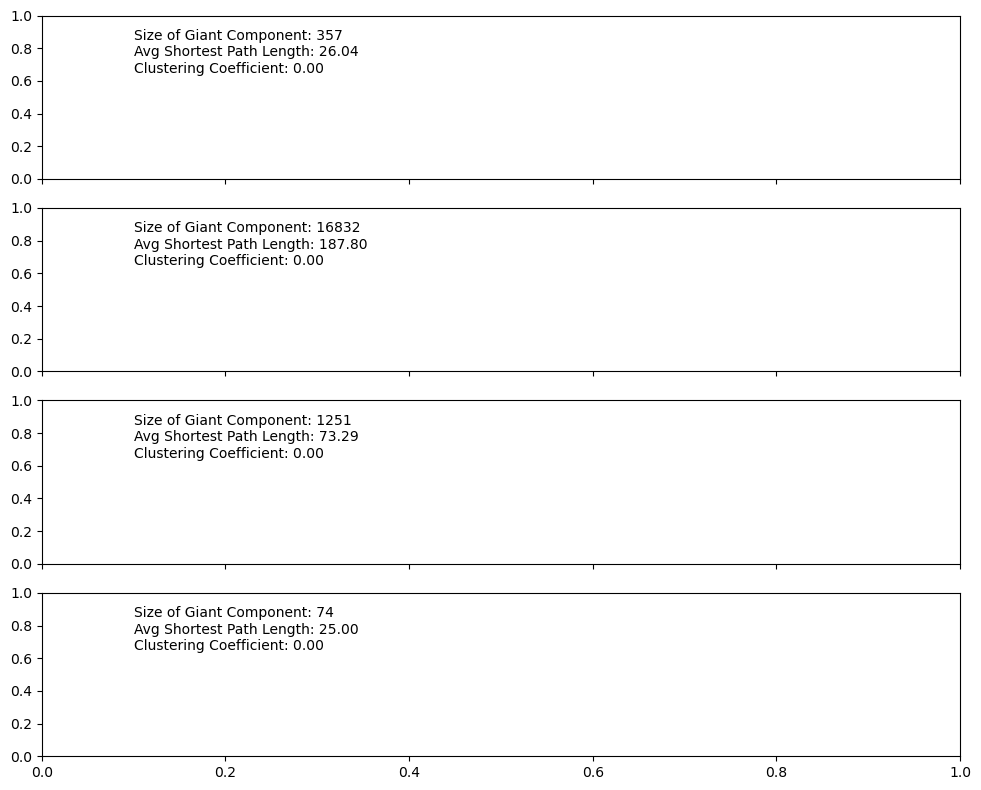

In [156]:
perform_attack_analysis(G)

In [139]:
nx.is_connected(S_simple)

True

In [149]:
betweenness = np.load('between.npy',allow_pickle='TRUE').item()